In [11]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
from ImageLoader import ImageLoader2D

In [12]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "DuckNet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 200
min_loss_for_saving = 0.9

In [14]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 100


100it [00:10,  9.59it/s]


In [15]:
# from sklearn.model_selection import KFold

# seed_value = 42
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)

# for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#     if fold == 0:
#         x_train, x_test = X[train_idx], X[test_idx]
#         y_train, y_test = Y[train_idx], Y[test_idx]

#         x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle=True, random_state=seed_value)

#         print(f"Selected Fold: {fold + 1}")
#         print("Training Set:", x_train.shape, y_train.shape)
#         print("Validation Set:", x_valid.shape, y_valid.shape)
#         print("Test Set:", x_test.shape, y_test.shape)

In [16]:
# Splitting the data, seed for reproducibility
seed_value = 42
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)
print(f"Using random seed {seed_value}")
print(f"Train Set Size {len(x_train)}")
print(f"Valid Set Size {len(x_valid)}")
print(f"Test Set Size {len(x_test)}")


Using random seed 42
Train Set Size 80
Valid Set Size 10
Test Set Size 10


In [17]:
# Defining the augmentations

aug__horizon_train = albu.Compose([
    albu.HorizontalFlip(),
])

aug__vertical_train = albu.Compose([
    albu.VerticalFlip(),
])

aug__color_train = albu.Compose([
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
])

aug__affine_train = albu.Compose([
    albu.Affine(),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        horizon = aug__horizon_train(image=x_train[i], mask=y_train[i])
        vertical = aug__vertical_train(image=x_train[i], mask=y_train[i])
        color = aug__color_train(image=x_train[i], mask=y_train[i])
        affine = aug__affine_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(horizon['image'])  
        y_train_out.append(horizon['mask'])
        # x_train_out.append(vertical['image'])  
        # y_train_out.append(vertical['mask'])
        x_train_out.append(color['image'])  
        y_train_out.append(color['mask'])
        x_train_out.append(affine['image'])  
        y_train_out.append(affine['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [18]:
# Creating the model

model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)

Starting DUCK-Net


In [19]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [20]:
# Training the model
tf.keras.backend.clear_session()

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    print(f"Size of Augment Images : {len(image_augmented)}")
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=2, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 79s 426ms/step - loss: 0.5990 - val_loss: 0.7999
Loss Validation: 0.7972821
Loss Test: 0.86180717
Saved model with val_loss:  0.7972821


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 1
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 409ms/step - loss: 0.4843 - val_loss: 0.6781
Loss Validation: 0.67722917
Loss Test: 0.7542535
Saved model with val_loss:  0.67722917


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 2
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 410ms/step - loss: 0.4292 - val_loss: 0.4954
Loss Validation: 0.4859795
Loss Test: 0.53764033
Saved model with val_loss:  0.4859795


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 3
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 411ms/step - loss: 0.4052 - val_loss: 0.5815
Loss Validation: 0.5876069
Loss Test: 0.6868388
Training, epoch 4
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 411ms/step - loss: 0.3653 - val_loss: 0.5032
Loss Validation: 0.52005583
Loss Test: 0.58770263
Training, epoch 5
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 50s 413ms/step - loss: 0.3441 - val_loss: 0.4502
Loss Validation: 0.441252
Loss Test: 0.47839922
Saved model with val_loss:  0.441252


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 6
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 412ms/step - loss: 0.3112 - val_loss: 0.4425
Loss Validation: 0.43161047
Loss Test: 0.45899594
Saved model with val_loss:  0.43161047


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 7
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 411ms/step - loss: 0.2920 - val_loss: 0.3831
Loss Validation: 0.3792994
Loss Test: 0.35870534
Saved model with val_loss:  0.3792994


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 8
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 49s 411ms/step - loss: 0.2711 - val_loss: 0.3800
Loss Validation: 0.377899
Loss Test: 0.34038407
Saved model with val_loss:  0.377899


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 9
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 396ms/step - loss: 0.2489 - val_loss: 0.3582
Loss Validation: 0.3614545
Loss Test: 0.33562952
Saved model with val_loss:  0.3614545


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 10
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 397ms/step - loss: 0.2373 - val_loss: 0.3419
Loss Validation: 0.3547998
Loss Test: 0.33749282
Saved model with val_loss:  0.3547998


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 11
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 398ms/step - loss: 0.2237 - val_loss: 0.3488
Loss Validation: 0.3541397
Loss Test: 0.3568591
Saved model with val_loss:  0.3541397


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 12
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 397ms/step - loss: 0.2004 - val_loss: 0.3398
Loss Validation: 0.348603
Loss Test: 0.37162232
Saved model with val_loss:  0.348603


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 13
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 397ms/step - loss: 0.1841 - val_loss: 0.3268
Loss Validation: 0.3288586
Loss Test: 0.3093714
Saved model with val_loss:  0.3288586


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 14
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 398ms/step - loss: 0.1639 - val_loss: 0.3741
Loss Validation: 0.3689778
Loss Test: 0.35108095
Training, epoch 15
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 398ms/step - loss: 0.1552 - val_loss: 0.3198
Loss Validation: 0.32110465
Loss Test: 0.25518227
Saved model with val_loss:  0.32110465


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 16
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 397ms/step - loss: 0.1461 - val_loss: 0.3634
Loss Validation: 0.36887896
Loss Test: 0.3258105
Training, epoch 17
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 398ms/step - loss: 0.1308 - val_loss: 0.3296
Loss Validation: 0.3311116
Loss Test: 0.2730751
Training, epoch 18
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 397ms/step - loss: 0.1232 - val_loss: 0.2705
Loss Validation: 0.2808258
Loss Test: 0.20385158
Saved model with val_loss:  0.2808258


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 19
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 48s 398ms/step - loss: 0.1202 - val_loss: 0.3583
Loss Validation: 0.36703032
Loss Test: 0.49303132
Training, epoch 20
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 44s 368ms/step - loss: 0.1154 - val_loss: 0.2561
Loss Validation: 0.27249414
Loss Test: 0.19365436
Saved model with val_loss:  0.27249414


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 21
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 342ms/step - loss: 0.1118 - val_loss: 0.2595
Loss Validation: 0.25900275
Loss Test: 0.19073033
Saved model with val_loss:  0.25900275


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 22
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 342ms/step - loss: 0.0976 - val_loss: 0.2702
Loss Validation: 0.28498697
Loss Test: 0.17840582
Training, epoch 23
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0928 - val_loss: 0.2574
Loss Validation: 0.27159023
Loss Test: 0.21573782
Training, epoch 24
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 342ms/step - loss: 0.0862 - val_loss: 0.2358
Loss Validation: 0.23870254
Loss Test: 0.22091323
Saved model with val_loss:  0.23870254


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 25
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0895 - val_loss: 0.3551
Loss Validation: 0.35430783
Loss Test: 0.33239287
Training, epoch 26
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 342ms/step - loss: 0.0778 - val_loss: 0.2563
Loss Validation: 0.26570517
Loss Test: 0.19367832
Training, epoch 27
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0813 - val_loss: 0.2345
Loss Validation: 0.24927437
Loss Test: 0.22026241
Training, epoch 28
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0761 - val_loss: 0.2946
Loss Validation: 0.30664295
Loss Test: 0.26185519
Training, epoch 29
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 342ms/step - loss: 0.0711 - val_los

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 30
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0760 - val_loss: 0.2414
Loss Validation: 0.25179094
Loss Test: 0.17122978
Training, epoch 31
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0670 - val_loss: 0.2561
Loss Validation: 0.27122676
Loss Test: 0.19998491
Training, epoch 32
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0650 - val_loss: 0.2915
Loss Validation: 0.29562467
Loss Test: 0.19160771
Training, epoch 33
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0646 - val_loss: 0.2383
Loss Validation: 0.24222392
Loss Test: 0.18402123
Training, epoch 34
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0576 - val_los

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 35
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0599 - val_loss: 0.2142
Loss Validation: 0.22771287
Loss Test: 0.18765652
Training, epoch 36
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0597 - val_loss: 0.2310
Loss Validation: 0.2395407
Loss Test: 0.22114247
Training, epoch 37
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0563 - val_loss: 0.2330
Loss Validation: 0.23232538
Loss Test: 0.23319936
Training, epoch 38
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0524 - val_loss: 0.2290
Loss Validation: 0.23201329
Loss Test: 0.18576342
Training, epoch 39
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0508 - val_loss

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 42
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0479 - val_loss: 0.2363
Loss Validation: 0.23068392
Loss Test: 0.18361098
Training, epoch 43
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0468 - val_loss: 0.2228
Loss Validation: 0.22529852
Loss Test: 0.18558627
Training, epoch 44
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0441 - val_loss: 0.2371
Loss Validation: 0.24515843
Loss Test: 0.21919268
Training, epoch 45
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0460 - val_loss: 0.2539
Loss Validation: 0.25087267
Loss Test: 0.1941241
Training, epoch 46
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 343ms/step - loss: 0.0430 - val_loss

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 100
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0205 - val_loss: 0.2223
Loss Validation: 0.2254166
Loss Test: 0.172063
Training, epoch 101
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0188 - val_loss: 0.1964
Loss Validation: 0.19952881
Loss Test: 0.18120939
Training, epoch 102
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0201 - val_loss: 0.1818
Loss Validation: 0.18484765
Loss Test: 0.19844049
Training, epoch 103
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0212 - val_loss: 0.2083
Loss Validation: 0.21259916
Loss Test: 0.16815227
Training, epoch 104
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0196 - val_l

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2024_4_4_15_44_10\assets


Training, epoch 131
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0178 - val_loss: 0.2218
Loss Validation: 0.22940874
Loss Test: 0.1801951
Training, epoch 132
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0174 - val_loss: 0.2097
Loss Validation: 0.21642041
Loss Test: 0.16999924
Training, epoch 133
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 344ms/step - loss: 0.0167 - val_loss: 0.1987
Loss Validation: 0.20021707
Loss Test: 0.16771328
Training, epoch 134
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 345ms/step - loss: 0.0161 - val_loss: 0.2350
Loss Validation: 0.2399345
Loss Test: 0.18984467
Training, epoch 135
Learning Rate: 0.0001
Size of Augment Images : 240
120/120 [==============================] - 41s 345ms/step - loss: 0.0152 - val_

In [21]:
import cv2

def postproccessing(image):
    kernels = [5, 10, 15]
    for k in kernels: 
        kernel = np.ones((k,k), np.uint8)
        # opening
        erosion1 = cv2.erode(image, kernel, iterations = 1)
        dilation1 = cv2.dilate(erosion1, kernel, iterations = 1)

        # closing
        dilation2 = cv2.dilate(dilation1, kernel, iterations = 1)
        erosion2 = cv2.erode(dilation2, kernel, iterations = 1)
        
        image = erosion2
    

    return image

Loading the model
3/3 [==============================] - 0s 127ms/step
results_DuckNet_17_kvasir.txt


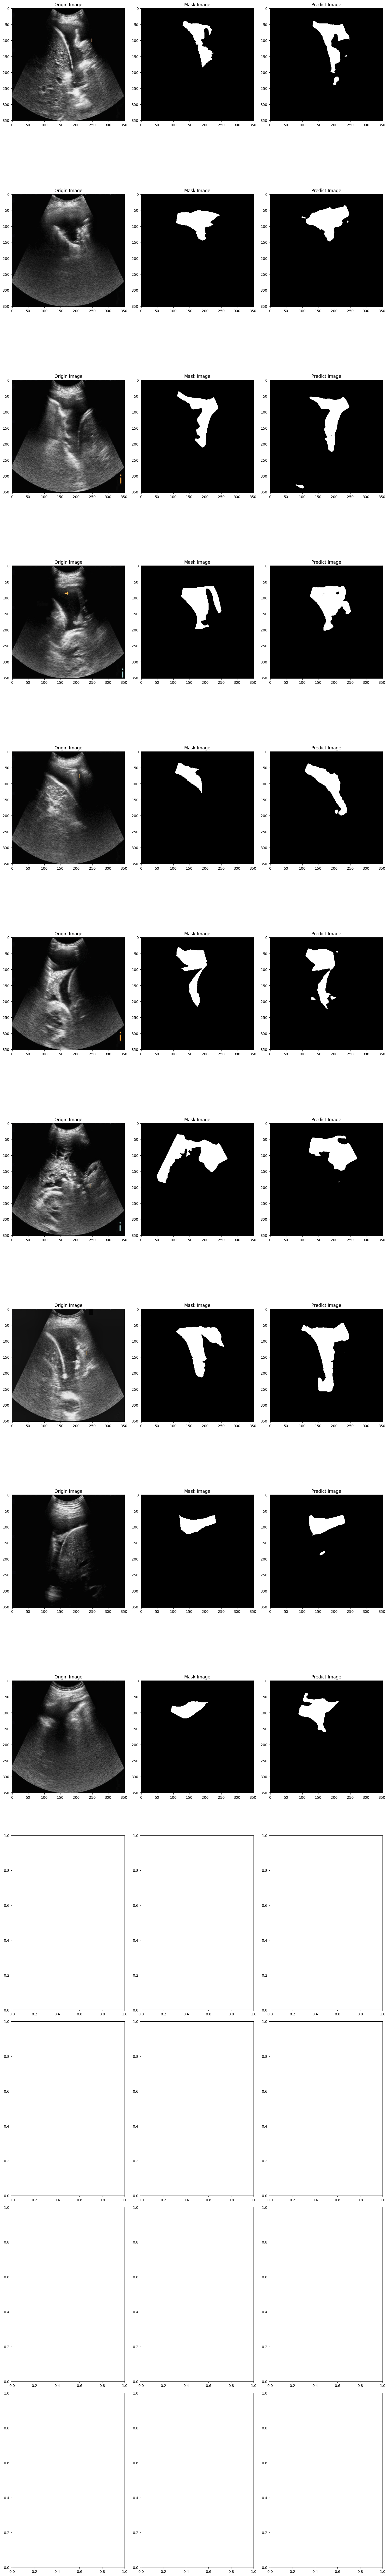

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
File done


In [22]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

# for i in range(len(prediction_test)):
    
#     prediction_test[i] = postproccessing(prediction_test[i])

fig, axs = plt.subplots(14, 3, figsize=(15, 100))

final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')

    # 計算個別數值
    dice_value = f1_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                         np.ndarray.flatten(prediction_test[i] > 0.5))
    miou_value = jaccard_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                              np.ndarray.flatten(prediction_test[i] > 0.5))
    precision_value = precision_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                      np.ndarray.flatten(prediction_test[i] > 0.5))
    recall_value = recall_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                np.ndarray.flatten(prediction_test[i] > 0.5))
    accuracy_value = accuracy_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                    np.ndarray.flatten(prediction_test[i] > 0.5))

    with open(final_file, 'a') as f:
        f.write(f'Metrics for sample {i + 1}:\n')
        f.write(f'Dice: {dice_value}\n')
        f.write(f'MIOU: {miou_value}\n')
        f.write(f'Precision: {precision_value}\n')
        f.write(f'Recall: {recall_value}\n')
        f.write(f'Accuracy: {accuracy_value}\n')
        f.write('\n')
        
plt.tight_layout()
plt.show()


print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')